# Inferenza bayesiana su una media {#sec-stan-one-mean}

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
import os
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import itertools
import logging
import statistics as stat
import cmdstanpy
from cmdstanpy import CmdStanModel

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

In [2]:
seed: int = sum(map(ord, "beta_binomial_model"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'psicometria')

## Introduzione {.unnumbered}

L'obiettivo principale di questo capitolo è esaminare un contesto che abbiamo già preso in considerazione in precedenza: ci troviamo di fronte a un campione di dati misurati su una scala a intervalli o rapporti e desideriamo effettuare inferenze sulla media della popolazione da cui il campione è stato estratto. Tuttavia, anziché procedere con una derivazione analitica della distribuzione a posteriori della media della popolazione, in questo caso utilizzeremo i metodi MCMC con Stan.

## Il modello Normale

I priori coniugati Normali di una Normale non richiedono l'approssimazione numerica ottenuta mediante metodi MCMC. In questo capitolo, tuttavia, ripetiamo l'esercizio descritto nel capitolo @sec-distr-coniugate-2 usando Stan.

### Un esempio concreto

Per applicare il modello Normale, utilizzeremo i dati del censimento parziale dell'area di Dobe dei !Kung San, raccolti attraverso interviste condotte da Nancy Howell alla fine degli anni '60. I !Kung San sono una suddivisione della popolazione San, che vive nel deserto del Kalahari, tra Namibia, Botswana e Angola, e mantengono un'economia basata su caccia e raccolta. Riprodurremo l'analisi descritta da @McElreath_rethinking, esaminando unicamente i valori dell'altezza di individui di età superiore ai 18 anni.

In [3]:
df = pd.read_csv('../../data/Howell_18.csv')
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
len(df["height"])

352

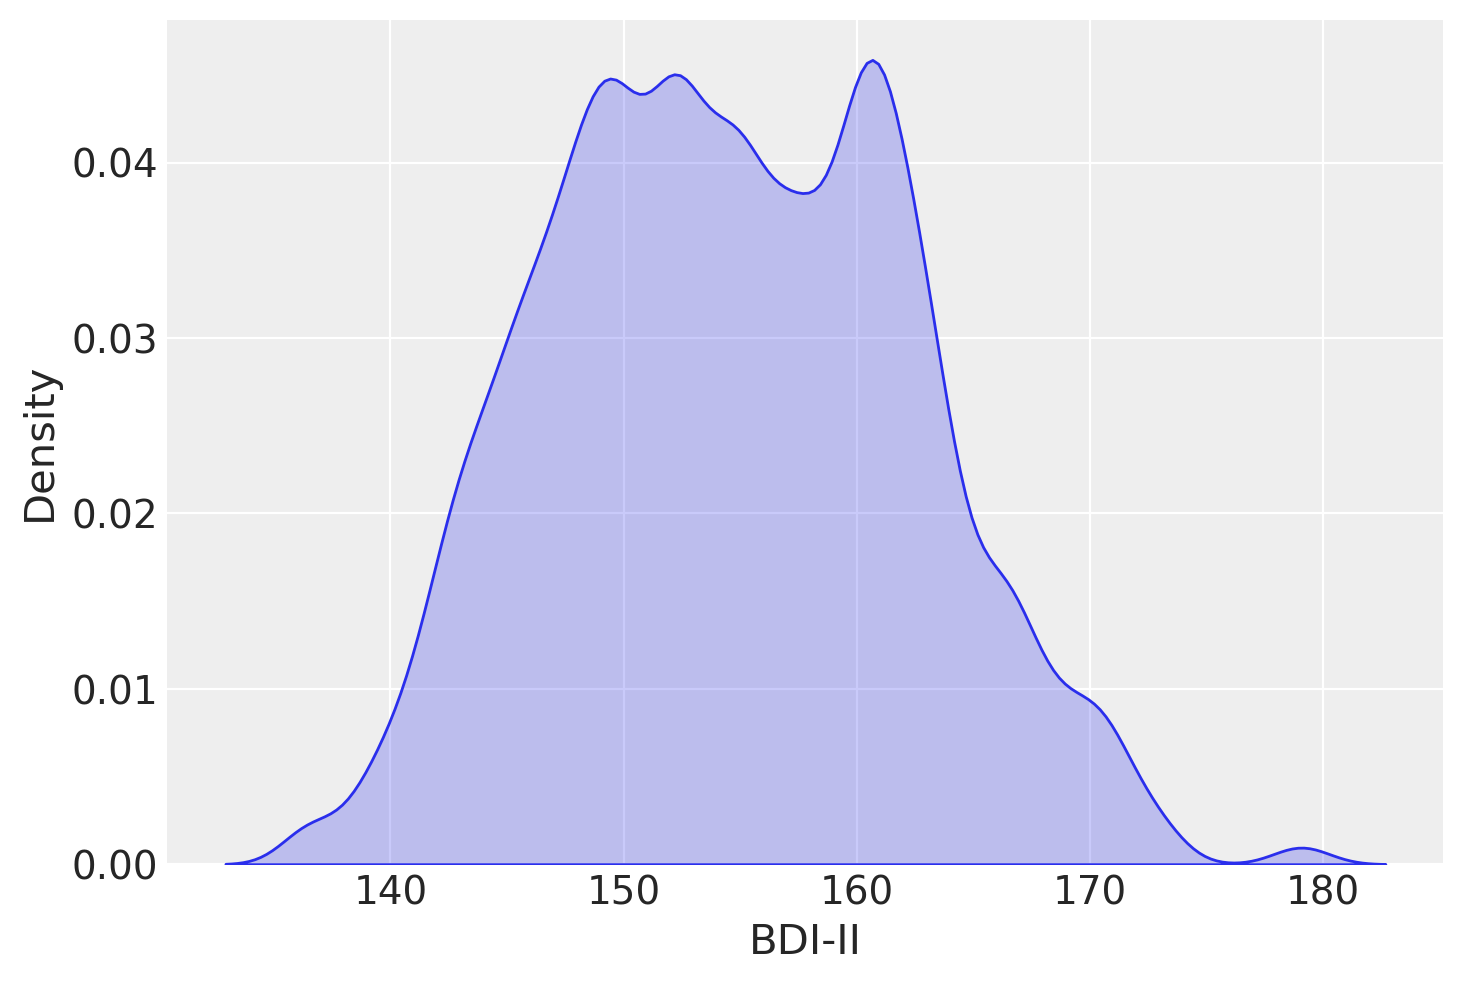

In [5]:
sns.kdeplot(df["height"], bw_adjust=0.5, fill=True)  # Adjust bw_adjust for smoothing
plt.xlabel("BDI-II")
plt.ylabel("Density")
plt.show()

La media dei valori dell'altezza nel campione è:

In [6]:
np.mean(df["height"])

154.5970926136364

con una deviazione standard pari a:

In [7]:
np.std(df["height"], ddof=1)

7.742332137351995

### Modello di Base 

Impostiamo una distribuzione a priori $\mathcal{N}(181, 30)$ per il parametro $\mu$ e una distribuzione a priori $\mathcal{N}(0, 20)$ per il parametro $\sigma$. Seguendo @McElreath_rethinking, ho impostato la distribuzione a priori per $\mu$ sul valore della mia altezza, per incorporare nel modello le mie conoscenze precedenti rispetto ai valori dell'altezza.

Pertanto, il modello Normale si definisce nel modo seguente:

$$
\begin{align}
Y_i &\sim \mathcal{N}(\mu, \sigma) \notag\\
\mu &\sim \mathcal{N}(181, 30) \notag\\
\sigma &\sim \mathcal{N}(0, 20) \notag
\end{align}
$$

Con questa specifica del modello:

- La variabile casuale $Y_i$ segue una distribuzione normale con parametri $\mu$ e $\sigma$.

- Il parametro $\mu$ ha una distribuzione a priori normale con media 181 e deviazione standard 30.

- Il parametro $\sigma$ ha una distribuzione a priori normale con deviazione standard 20, troncata inferiormente a 0.

Per $\sigma$, la normale troncata con deviazione standard pari a 20 permette una grande variabilità, garantendo valori positivi per la deviazione standard della distribuzione normale di $Y_i$. I parametri $\mu$ e $\sigma$ sono sconosciuti e rappresentano l'oggetto dell'inferenza. 

In [9]:
stan_file = os.path.join(project_directory, 'stan', 'gaussian_height.stan')
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
    int<lower=1> N;
    vector[N] y;
}
parameters {
    real mu;
    real<lower=0> sigma;
}
model {
  y ~ normal(mu, sigma);
  sigma ~ normal(0, 20);
  mu ~ normal(181, 30);
}



Creaiamo un dizionario con i dati in formato appropriato per Stan:

In [ ]:
stan_data = {
    'N': len(df["height"]), 
    'y': df["height"]
}
print(stan_data)

{'N': 352, 'y': 0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
347    162.560
348    142.875
349    162.560
350    156.210
351    158.750
Name: height, Length: 352, dtype: float64}


Eseguiamo il campionamento:

In [11]:
trace = model.sample(
    data=stan_data,
    iter_warmup=1000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

Esaminiamo le distribuzioni a posteriori dei due parametri oggetto dell'inferenza insieme alle loro tracce (cioè i vettori dei campioni dei parametri $\mu$ e $\sigma$ prodotti dalla procedura di campionamento MCMC) mediante un *trace plot* .

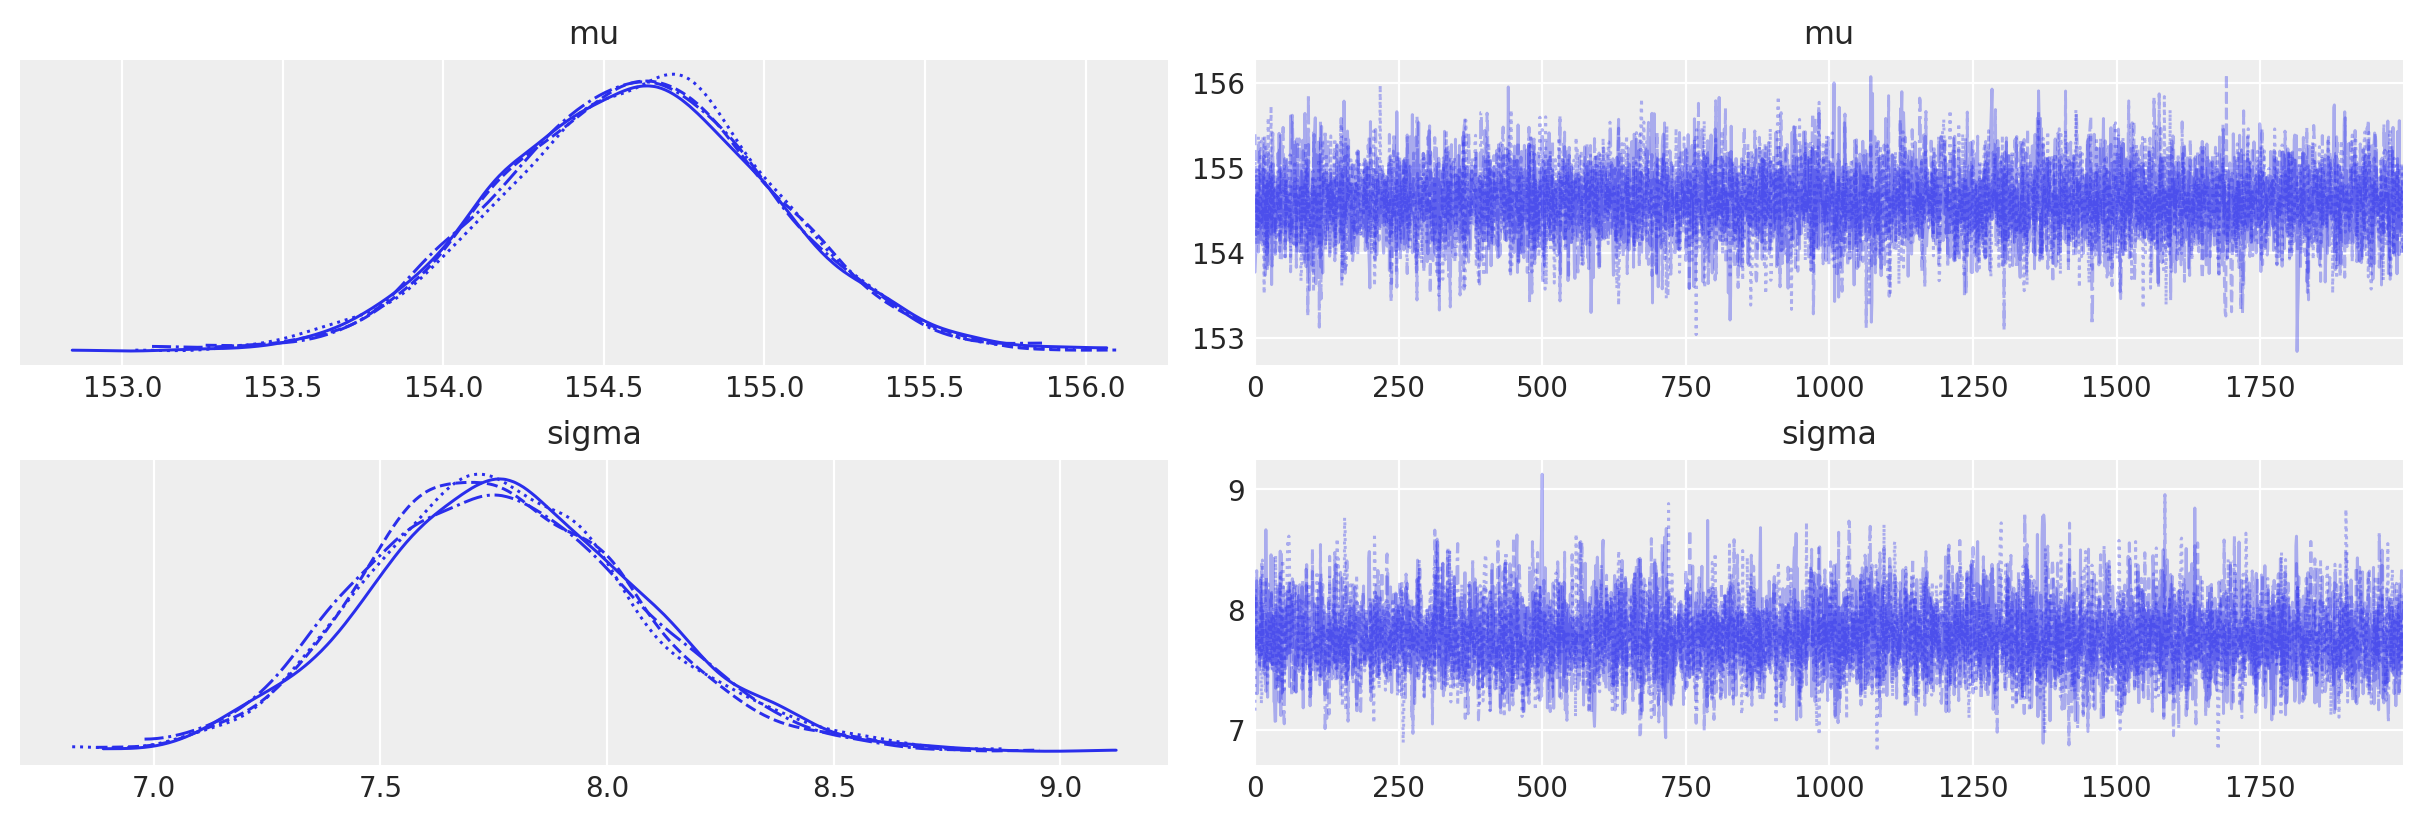

In [12]:
_ = az.plot_trace(trace)

Una sintesi delle distribuzioni a posteriori dei parametri si ottiene nel modo seguente. 

In [13]:
az.summary(trace, hdi_prob=0.94, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.60,0.42,153.84,155.39,0.0,0.0,7864.52,5825.33,1.0
sigma,7.77,0.30,7.21,8.34,0.0,0.0,6655.48,5167.04,1.0


## Parametrizzazione Non Centrata

Nella versione precedente del modello Normale abbiamo specificato le distribuzioni a priori per i parametri oggetto dell'inferenza ($\mu$ e $\sigma$) sulla scala dei dati grezzi osservati, i quali hanno una media di 154.6 e una deviazione standard di 7.7. Sul parametro $\mu$ abbiamo imposto una distribuzione a priori normale con media 181 e deviazione standard 30, e sul parametro $\sigma$ abbiamo imposto una distribuzione a priori normale con media 0 e deviazione standard 20. Queste distribuzioni a priori sono specifiche per ciascun particolare campione che possiamo osservare. 

È possibile usare un approccio diverso, che consente di definire delle distribuzioni a priori sui parametri che sono indipendenti dal particolare campione che osserviamo. Questa procedura è chiamata "parametrizzazione non centrata" (*non-centered parametrization*). In questo modello, utilizziamo variabili latenti $\mu_{\text{raw}}$ e $\sigma_{\text{raw}}$, che seguono una distribuzione normale standard:

$$
\begin{align}
\mu_{\text{raw}} &\sim \mathcal{N}(0, 1) \notag\\
\sigma_{\text{raw}} &\sim \mathcal{N}(0, 1) \notag
\end{align}
$$

Queste variabili vengono poi trasformate per ottenere i parametri $\mu$ e $\sigma$ sulla scala originale:

$$
\begin{align}
\mu &= y_{\text{mean}} + y_{\text{sd}} \cdot \mu_{\text{raw}} \notag\\
\sigma &= y_{\text{sd}} \cdot \sigma_{\text{raw}} \notag
\end{align}
$$

Dove:
- $y_{\text{mean}}$ è la media dei dati osservati $y$.
- $y_{\text{sd}}$ è la deviazione standard dei dati osservati $y$.

In [14]:
stan_ncp_file = os.path.join(project_directory, 'stan', 'gaussian_ncp.stan')
model_ncp = CmdStanModel(stan_file=stan_ncp_file)

Di seguito è riportato il codice Stan per questo modello con la parametrizzazione non centrata:

In [15]:
print(model_ncp.code())

data {
    int<lower=1> N;
    vector[N] y;
}
transformed data {
    real y_mean = mean(y);
    real y_sd = sd(y);
}
parameters {
    real mu_raw;
    real<lower=0> sigma_raw;
}
transformed parameters {
    real mu;
    real<lower=0> sigma;
    mu = y_mean + y_sd * mu_raw;
    sigma = y_sd * sigma_raw;
}
model {
    // Priors:
    mu_raw ~ normal(0, 1);
    sigma_raw ~ normal(0, 1);
    // Likelihood:
    y ~ normal(mu, sigma);
}
generated quantities {
    vector[N] y_rep;
    for (n in 1:N) {
        y_rep[n] = normal_rng(mu, sigma);
    }
}



Ecco una spiegazione dettagliata del modello Stan con parametrizzazione non centrata.

1. **Blocco Dati**:
   - `int<lower=1> N;`: Il numero totale di prove o osservazioni.
   - `vector[N] y;`: Il vettore dei punteggi osservati per ciascuna prova. Questi punteggi sono sulla loro scala originale e non standardizzati.

2. **Blocco Dati Trasformati**:
   - `real y_mean = mean(y);`: La media dei dati osservati `y`.
   - `real y_sd = sd(y);`: La deviazione standard dei dati osservati `y`.

3. **Blocco Parametri**:
   - `real mu_raw;`: Un parametro latente che segue una distribuzione normale standard.
   - `real<lower=0> sigma_raw;`: Un parametro latente che segue una distribuzione normale standard vincolata a essere positiva.

4. **Blocco Parametri Trasformati**:
   - `real mu;`: La media della distribuzione normale per `y` sulla sua scala originale.
   - `real<lower=0> sigma;`: La deviazione standard della distribuzione normale per `y` sulla sua scala originale.
   - Questi parametri trasformati sono definiti come:
     ```stan
     mu = y_mean + y_sd * mu_raw;
     sigma = y_sd * sigma_raw;
     ```

La **parametrizzazione non centrata** comporta la riparametrizzazione del modello in termini di variabili standardizzate (`mu_raw` e `sigma_raw`) e poi la loro trasformazione di nuovo sulla scala originale dei dati. Questo approccio spesso porta a una migliore efficienza di campionamento e proprietà di convergenza, specialmente nei modelli gerarchici.

1. **Parametri Latenti (`mu_raw` e `sigma_raw`)**:
   - `mu_raw ~ normal(0, 1);`: `mu_raw` è una variabile normale standardizzata.
   - `sigma_raw ~ normal(0, 1);`: `sigma_raw` è una variabile normale standardizzata vincolata a essere positiva.

2. **Trasformazione alla Scala Originale**:
   - `mu = y_mean + y_sd * mu_raw;`: Questo scala e trasla `mu_raw` alla posizione e scala dei dati osservati `y`.
   - `sigma = y_sd * sigma_raw;`: Questo scala `sigma_raw` alla scala dei dati osservati `y`.

La dichiarazione della verosimiglianza `y ~ normal(mu, sigma);` indica che i dati osservati `y` seguono una distribuzione normale con media `mu` e deviazione standard `sigma`. Ecco perché ha senso anche se `y` è sulla sua scala originale:

- **Dati Osservati sulla Scala Originale**: I dati osservati `y` sono sulla loro scala originale.
- **Parametri sulla Scala Originale**: I parametri `mu` e `sigma`, dopo la trasformazione nel blocco `transformed parameters`, sono anch'essi sulla scala originale di `y`.

Quindi, la dichiarazione `y ~ normal(mu, sigma);` specifica correttamente che i dati osservati `y` (sulla loro scala originale) sono modellati da una distribuzione normale con media `mu` e deviazione standard `sigma`, entrambe sulla scala originale di `y`.

Infine, il blocco `generated quantities` viene utilizzato per i controlli predittivi posteriori generando nuovi dati (`y_rep`) dalla distribuzione posteriore dei parametri (`mu` e `sigma`):

```stan
generated quantities {
    vector[N] y_rep;
    for (n in 1:N) {
        y_rep[n] = normal_rng(mu, sigma);
    }
}
```

- **`y_rep`**: Questo genera punti dati replicati dalla distribuzione normale con la media posteriore `mu` e la deviazione standard posteriore `sigma`. Questo ti permette di confrontare le previsioni del modello con i dati osservati per eseguire controlli predittivi posteriori.

Eseguiamo il campionamento MCMC per il modello che segue una parametrizzazione non centrata:

In [16]:
trace_ncp = model_ncp.sample(
    data=stan_data,
    iter_warmup=1000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

Esaminiamo la distribuzioni a posteriori e le tracce dei parametri $\mu$ e $\sigma$:

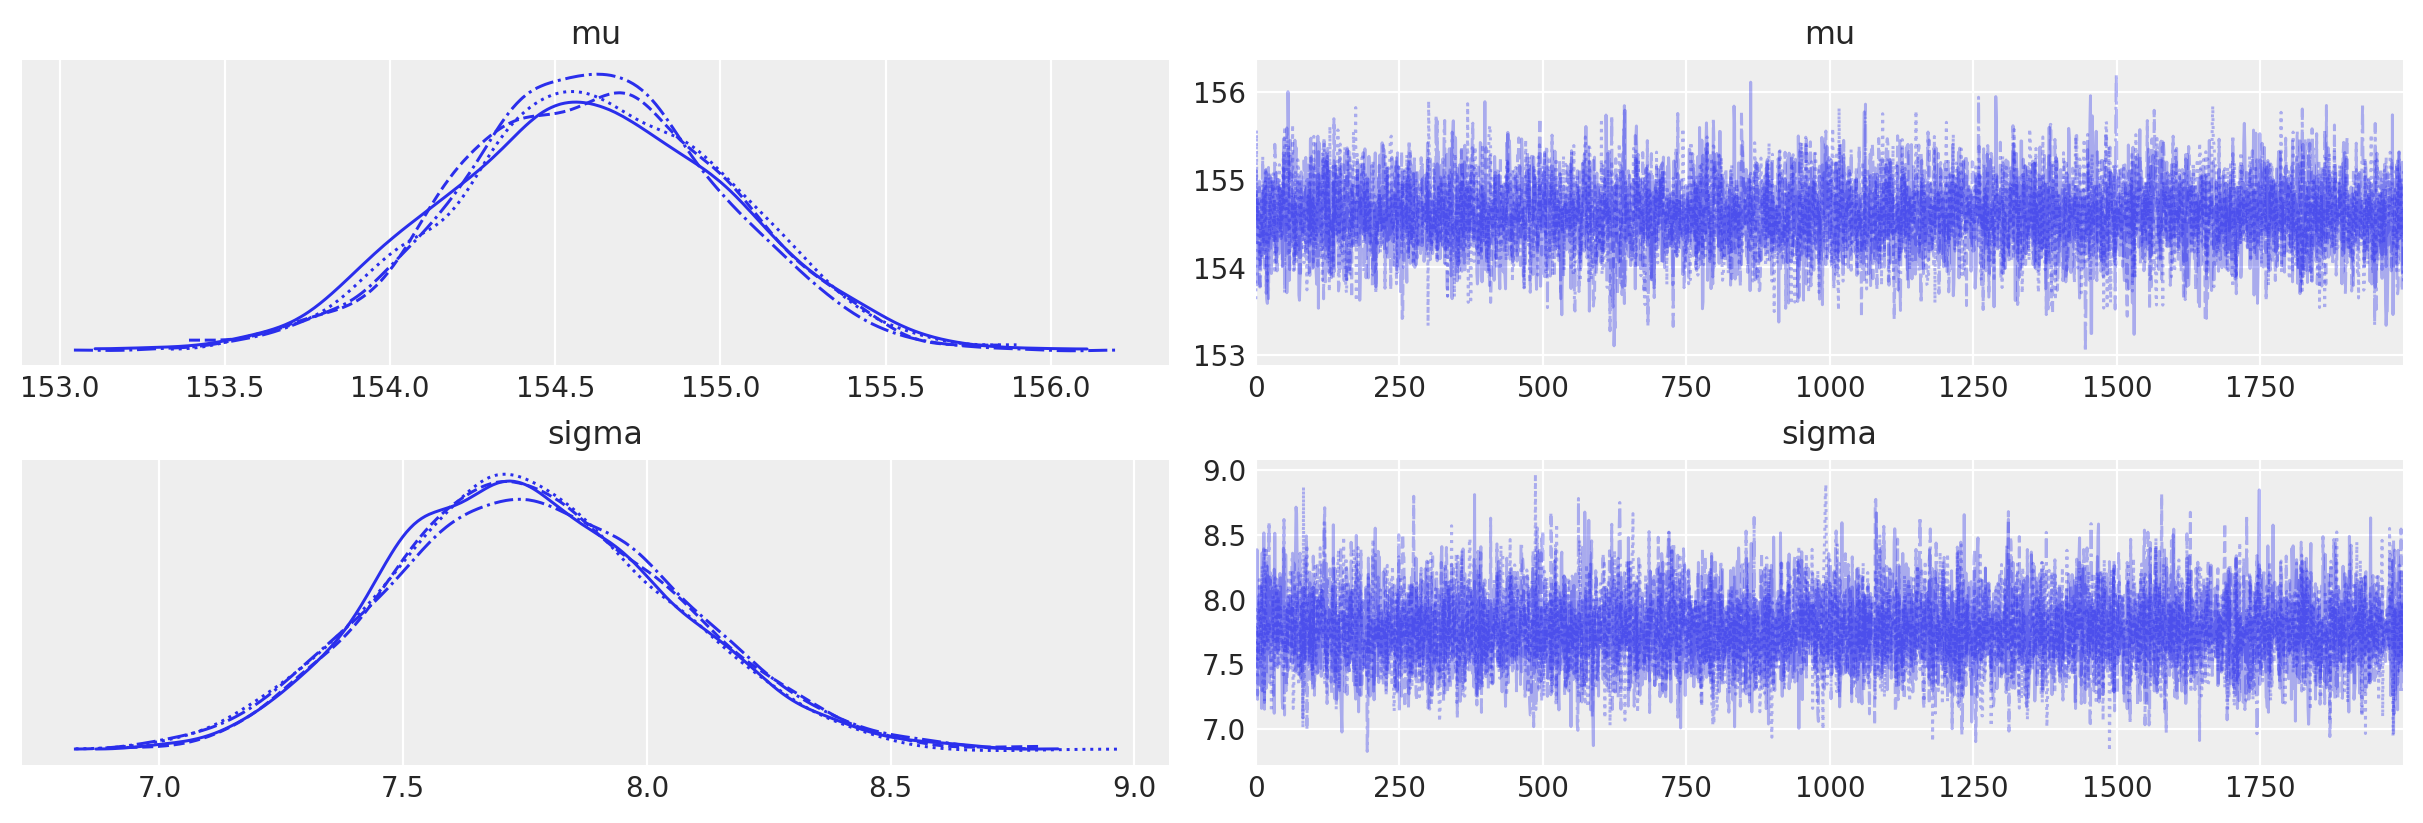

In [17]:
_ = az.plot_trace(trace_ncp, var_names=['mu', 'sigma'])

Otteniamo una sintesi delle distribuzioni a posteriori dei parametri:

In [18]:
summary = az.summary(trace_ncp, var_names=['mu', 'sigma'], round_to=2)
print(summary)

         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     154.61  0.42  153.83   155.39       0.01      0.0   6329.64   5029.29   
sigma    7.76  0.29    7.20     8.30       0.00      0.0   7836.78   5829.76   

       r_hat  
mu       1.0  
sigma    1.0  


I risultati sono molto simili a quelli ottenuti in precedenza. 

## Posterior predictive check

Uno dei vantaggi del toolkit bayesiano è che una volta ottenuta la distribuzione a posteriori congiunta dei parametri p(θ|Y) è possibile utilizzarla per generare le previsioni p(Ỹ). Matematicamente, questo può essere fatto calcolando:

$$
p(\tilde{y} \mid y) = \int p(\tilde{y} \mid \theta) p(\theta \mid y) d\theta.
$$

Questa distribuzione è nota come distribuzione predittiva posteriore. È predittiva perché viene utilizzata per fare previsioni e posteriore perché è calcolata utilizzando la distribuzione posteriore. Quindi possiamo pensare a questa come la distribuzione dei dati futuri dati il modello e i dati osservati.

Utilizzando Stan è facile per ottenere campioni predittivi posteriori: non è necessario calcolare alcun integrale. Dobbiamo convertire l'oggetto creato dalla funzione `sample()` nel formato  ArviZ InferenceData:

In [19]:
# Convert to ArviZ InferenceData object
idata = az.from_cmdstanpy(
    posterior=trace_ncp,
    posterior_predictive='y_rep',
    observed_data={"y": df["height"]}
)

Un uso comune della distribuzione predittiva posteriore è quello di eseguire controlli predittivi posteriori. Questi sono un insieme di test che possono essere utilizzati per verificare se il modello è una buona rappresentazione dei dati. Possiamo utilizzare la funzione `plot_ppc` di ArviZ per visualizzare la distribuzione predittiva posteriore e i dati osservati. Il codice è:

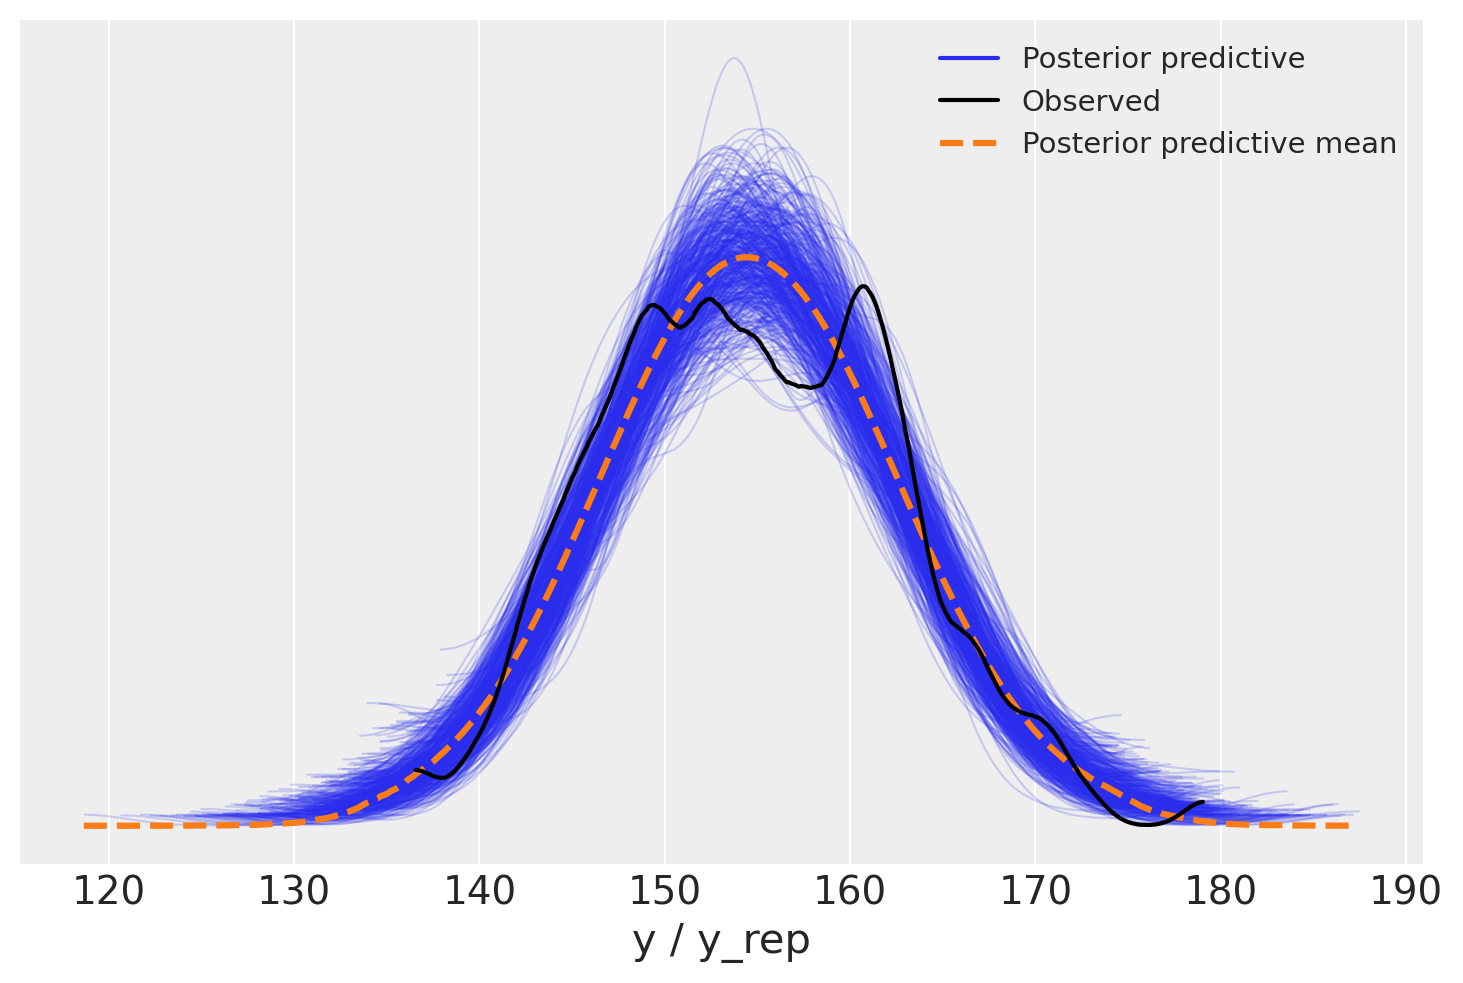

In [20]:
# Plot the posterior predictive check
_ = az.plot_ppc(idata, data_pairs={"y": "y_rep"}, num_pp_samples=500)

Nella figura, la linea nera rappresenta una KDE (Kernel Density Estimation) dei dati, mentre le linee blu sono KDE calcolate da ciascuno dei 500 campioni predittivi posteriori. Le linee blu riflettono l'incertezza associata alla distribuzione dei dati previsti.

Di default, in ArviZ le KDE vengono stimati all'interno dell'intervallo effettivo dei dati e si assume che siano zero al di fuori di questo intervallo.

Dato che il tracciato del KDE plot è contenuto nell'insieme di profili dei KDE plot dei campioni predittivi a posteriori, si può concludere che il modello utilizzato offre una rappresentazione adeguata dei dati ed è utile per la maggior parte delle analisi. Tuttavia, è importante considerare che potrebbero esistere altri modelli in grado di adattarsi meglio all'intero dataset. Esploreremo ora come poter sviluppare un modello alternativo.

## Modello "robusto"

Non è necessario presupporre che i dati seguano una distribuzione gaussiana. Le lievi deviazioni dalla gaussianità possono essere considerate attraverso l'utilizzo della distribuzione t di Student, che è particolarmente utile quando queste deviazioni si manifestano nelle code della distribuzione, come sembra essere il caso in questa situazione. Pertanto, proponiamo di adottare un modello 'robusto', maggiormente adatto a gestire osservazioni che si discostano dalla normalità nelle code della distribuzione.

La distribuzione t di Student è caratterizzata dal parametro $\nu$, noto come 'gradi di libertà'. Quando $\nu$ è pari o superiore a 30, la distribuzione t di Student diventa quasi indistinguibile da una distribuzione normale. 

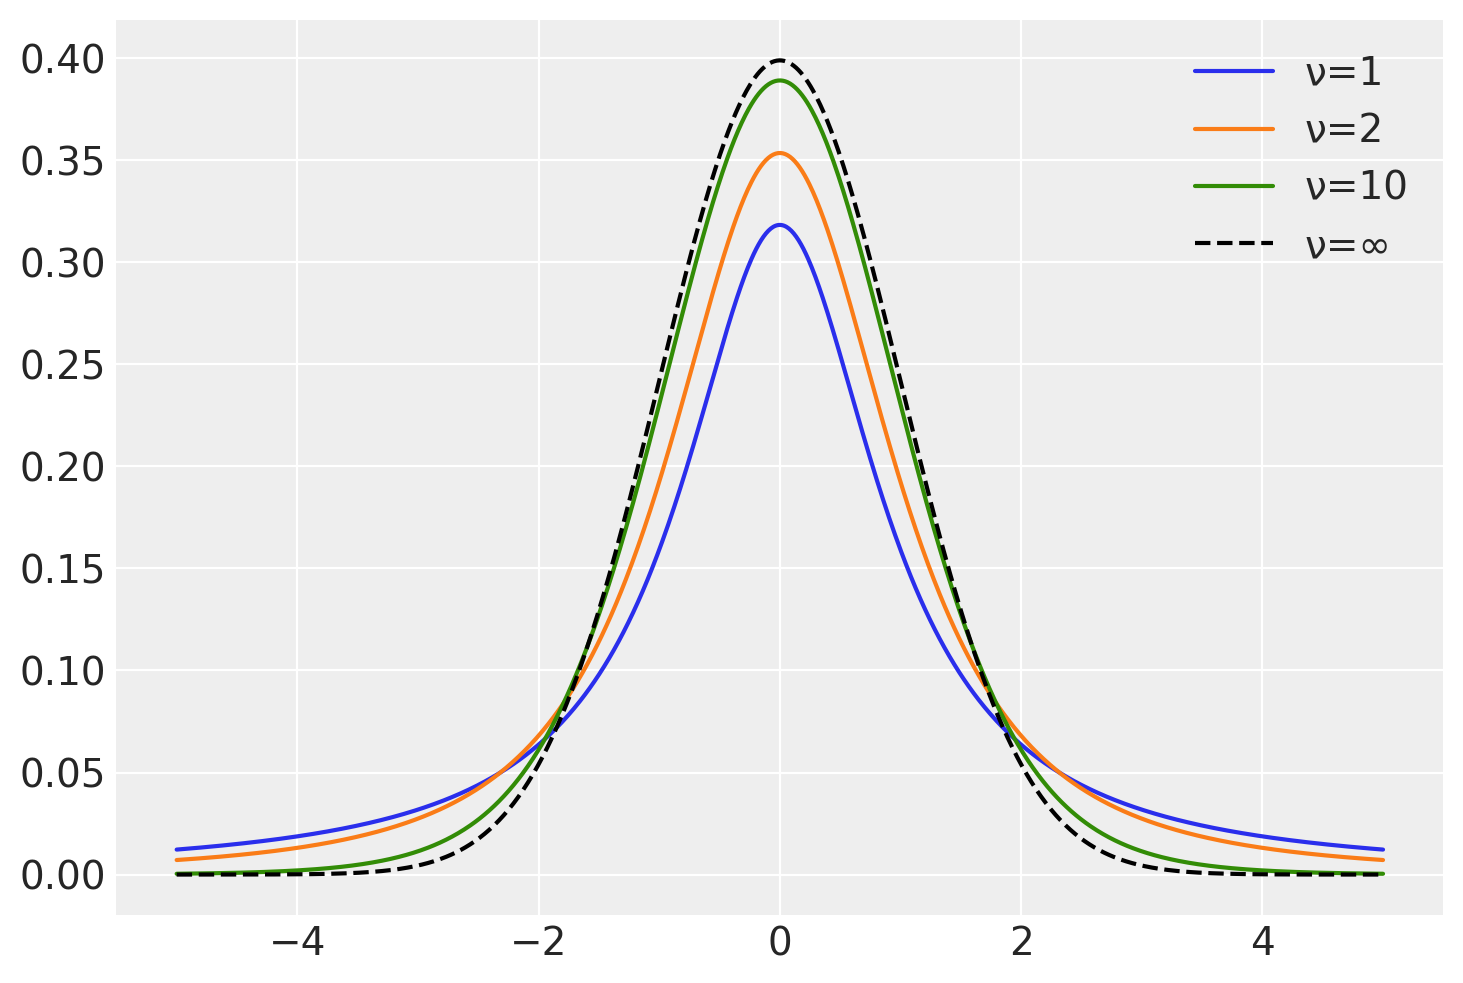

In [21]:
nu_values = [1, 2, 10]

fig, ax = plt.subplots()

for nu in nu_values:
    x = np.linspace(-5, 5, 1000)
    y = stats.t.pdf(x, df=nu, loc=0, scale=1)
    ax.plot(x, y, label=f"ν={nu}")

x = np.linspace(-5, 5, 1000)
y = stats.t.pdf(x, df=np.inf, loc=0, scale=1)
ax.plot(x, y, linestyle="--", color="k", label="ν=∞")

plt.legend()
plt.show()

Tuttavia, le code della distribuzione t di Student risultano più pesanti rispetto a quelle della normale quando $\nu$ è basso. Pertanto, proponiamo di assegnare a $\nu$ una distribuzione a priori che concentri la maggior parte della sua massa su valori bassi, come ad esempio una distribuzione esponenziale con un parametro di rate pari a 1/30.

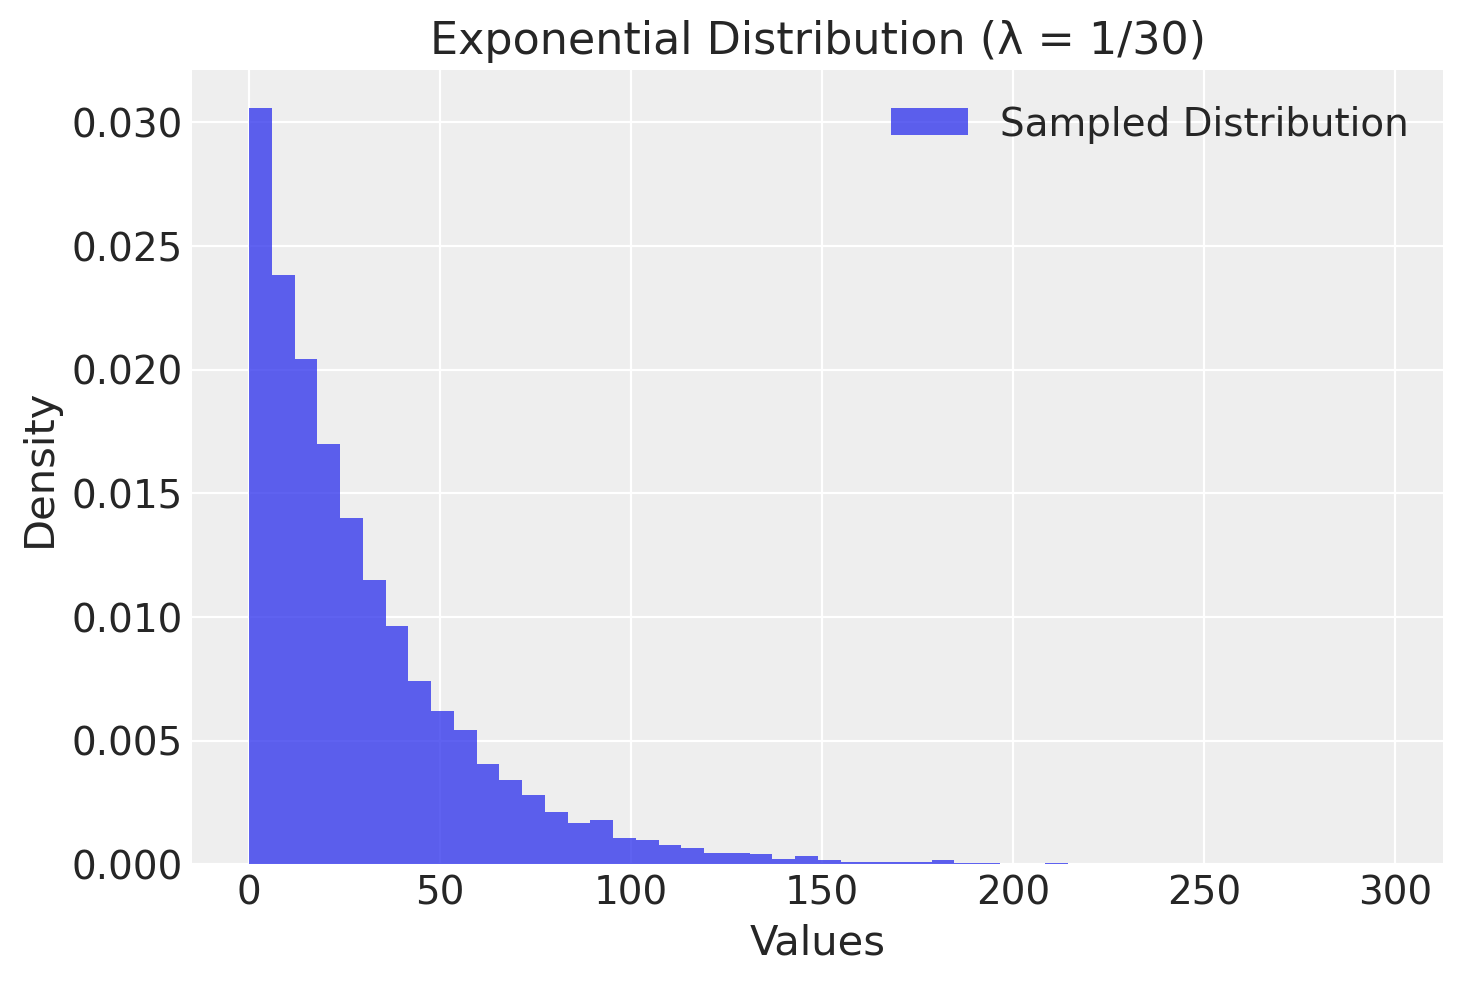

In [22]:
# Define the rate parameter for the exponential distribution
rate = 1 / 30

# Generate samples from the exponential distribution
samples = np.random.exponential(scale=1 / rate, size=10000)

# Create the histogram plot of the samples
plt.hist(samples, bins=50, density=True, alpha=0.75, label="Sampled Distribution")
plt.title("Exponential Distribution (λ = 1/30)")
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
stan_student_file = os.path.join(project_directory, 'stan', 'student-model.stan')
model_student = CmdStanModel(stan_file=stan_student_file)
print(model_student.code())

data {
    int<lower=1> N;  // Numero totale di prove
    vector[N] y;  // Punteggio in ciascuna prova
}
transformed data {
    real y_mean = mean(y);  // Media dei dati osservati
    real y_sd = sd(y);  // Deviazione standard dei dati osservati
}
parameters {
    real mu_raw;  // Parametro latente standardizzato per mu
    real<lower=0> sigma_raw;  // Parametro latente standardizzato per sigma
    real<lower=1> nu;  // Gradi di libertà per la distribuzione t di Student
}
transformed parameters {
    real mu;  // Media sulla scala originale
    real<lower=0> sigma;  // Deviazione standard sulla scala originale
    mu = y_mean + y_sd * mu_raw;
    sigma = y_sd * sigma_raw;
}
model {
    // Distribuzioni a priori non centrate
    mu_raw ~ normal(0, 1);
    sigma_raw ~ normal(0, 1);
    nu ~ exponential(1.0 / 30.0);  // Prior esponenziale per i gradi di libertà
    // Verosimiglianza
    y ~ student_t(nu, mu, sigma);
}
generated quantities {
    vector[N] y_rep;
    for (n in 1:N) {
     

In [24]:
trace_student = model_student.sample(
    data=stan_data,
    iter_warmup=1000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

Esaminiamo le distribuzioni a posteriori e le tracce dei parametri del nuovo modello. 

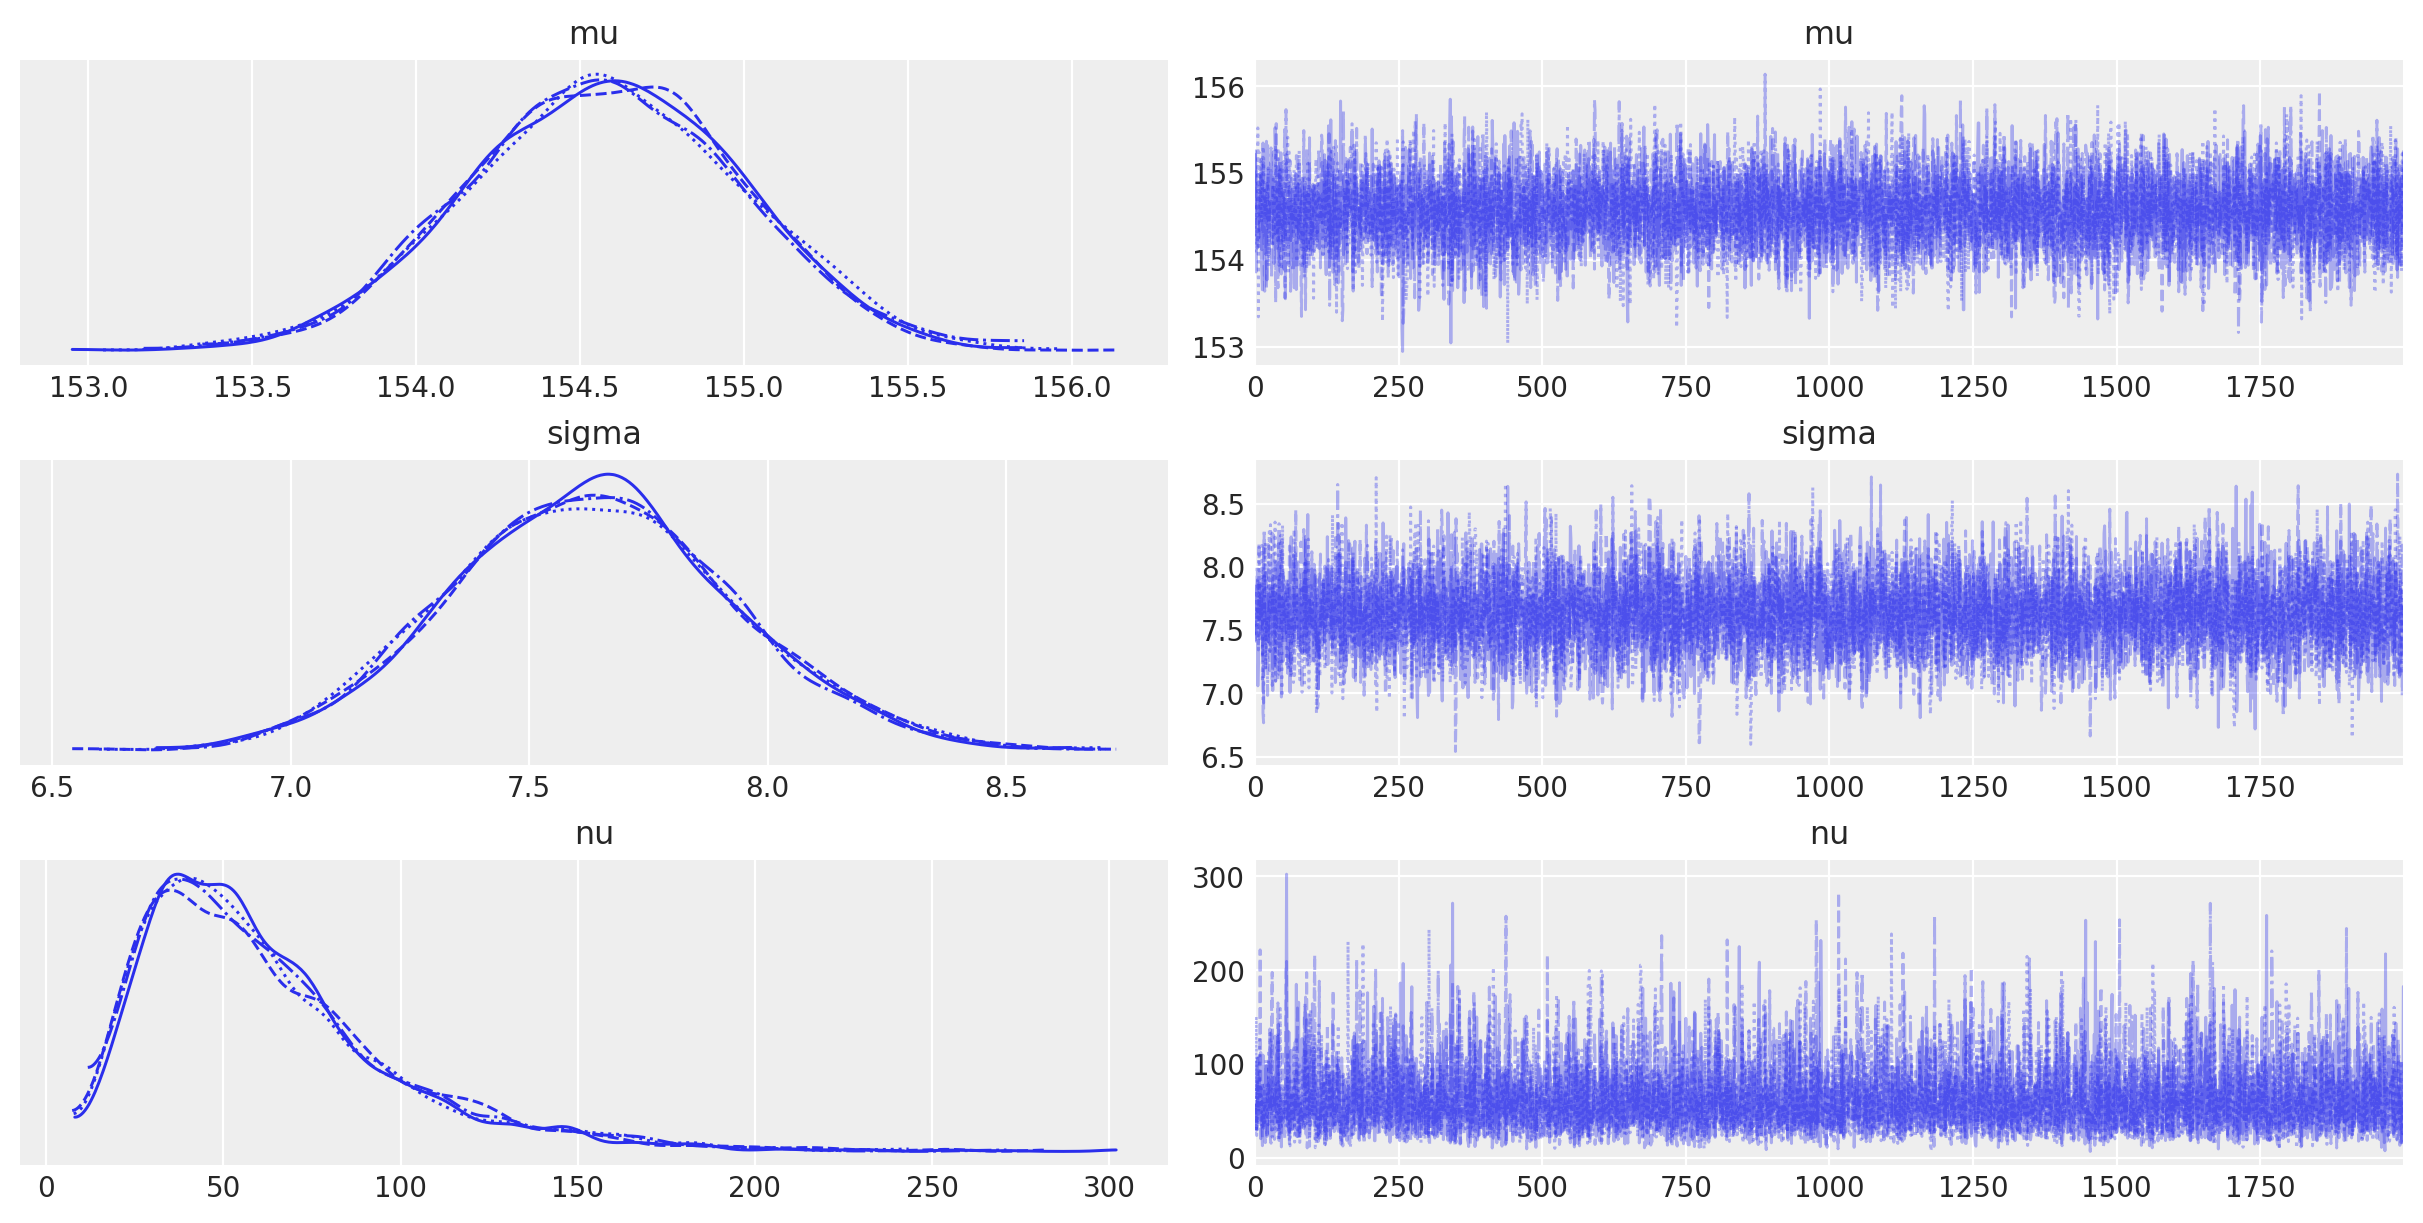

In [25]:
_ = az.plot_trace(trace_student, var_names=['mu', 'sigma', 'nu'])

Convertiamo i risultati in un oggetto InferenceData di ArviZ.

In [26]:
idata = az.from_cmdstanpy(
    posterior=trace_student,
    posterior_predictive='y_rep',
    observed_data={"y": df["height"]}
)

Generiamo la distribuzione predittiva a posteriori.

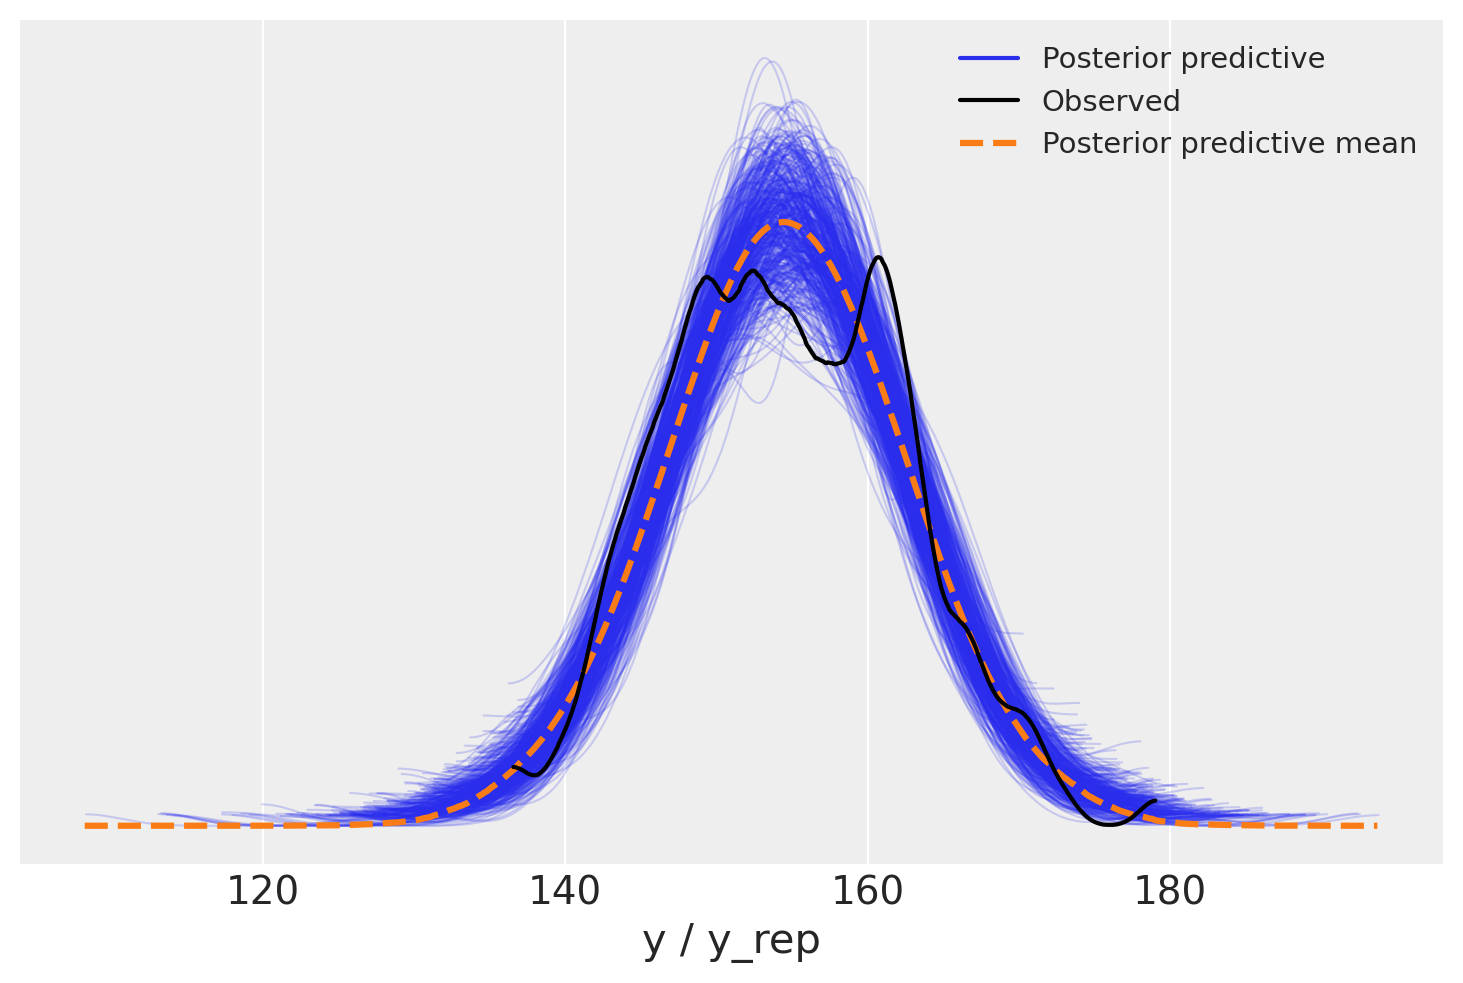

In [27]:
_ = az.plot_ppc(idata, data_pairs={"y": "y_rep"}, num_pp_samples=500)

La figura illustra che la situazione è analoga a quella del caso gaussiano. Questo non è sorprendente, dato che i dati relativi all'altezza si distribuiscono in maniera gaussiana nella popolazione. Pertanto, l'impiego della distribuzione t di Student o della distribuzione normale producono risultati sostanzialmente equivalenti in questo contesto. 

In [28]:
az.summary(trace_student, var_names=['mu', 'sigma', 'nu'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.57,0.42,153.85,155.40,0.00,0.00,8798.72,6040.50,1.0
sigma,7.63,0.30,7.08,8.21,0.00,0.00,7145.94,6226.65,1.0
nu,62.39,36.10,11.40,129.62,0.41,0.31,7870.31,5565.90,1.0


## Commenti e considerazioni finali

In questo capitolo abbiamo esplorato il metodo per calcolare l'intervallo di credibilità per la media di una variabile casuale normale utilizzando Stan. Inoltre, abbiamo illustrato come sia possibile ampliare l'inferenza sulla media utilizzando un modello robusto basato sulla distribuzione t di Student.

## Esercizi

::: {#exr-stan-normal-normal-1}

Utilizzando i dati dell'esempio sui bambini plusdotati discusso nella @sec-grid-gauss, impiegare Stan per replicare i risultati ottenuti con il metodo basato su griglia.

:::

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Thu Jul 25 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

logging   : 0.5.1.2
scipy     : 1.14.0
cmdstanpy : 1.2.4
arviz     : 0.18.0
pandas    : 2.2.2
seaborn   : 0.13.2
matplotlib: 3.9.1
numpy     : 1.26.4

Watermark: 2.4.3

